In [1]:
import ete3
import pandas as pd
import re
import numpy as np
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import pymc3 as pm

%cd ~/Dropbox (MIT)/IndexHGTAnalysis/modeldata

/Users/thiberio/Dropbox (MIT)/IndexHGTAnalysis/modeldata


In [2]:
def get_node_age_from_descendants(tree, descendants):
    node = tree.get_common_ancestor(descendants)
    return(node.support)

In [3]:
def assess_constraint_compatibility(constraint, posterior_trees):
    older_bound   = next( named_tree.iter_search_nodes(name=constraint.donor_node) )
    younger_bound = next( named_tree.iter_search_nodes(name=constraint.recipient_node) )
    
    compatibilities = []
    for tmp_tree in posterior_trees:
        older_bound_age   = get_node_age_from_descendants(tmp_tree,   older_bound.get_leaf_names())
        younger_bound_age = get_node_age_from_descendants(tmp_tree, younger_bound.get_leaf_names())
        
        if older_bound_age > younger_bound_age:
            compatibilities.append(True)
        else:
            compatibilities.append(False)

    return(compatibilities)

In [4]:
named_tree = ete3.Tree('Cyano_modelBB_ugam_bd_7_20_sample.labels', format=1)

In [5]:
HGT_constraints = pd.read_excel('HGTgpf4a.xlsx', sep=',')

HGT_constraints.donor_node     = HGT_constraints.donor_node.astype(str)
HGT_constraints.recipient_node = HGT_constraints.recipient_node.astype(str)

In [6]:
BE_posterior_trees = [ete3.Tree(line) 
                      for line in open('Cyano_modelBE_noChlorobact_cir_nobd_7_20_sample.datedist').readlines()]

In [7]:
len(BE_posterior_trees)

10000

In [8]:
BE_compatibility_table = pd.DataFrame()

for index, row in HGT_constraints.iterrows():
    BE_compatibility_table[row.label] = assess_constraint_compatibility(row,
                                                                        BE_posterior_trees)

In [9]:
num_trees, num_constraints = BE_compatibility_table.shape
num_compatibles            = BE_compatibility_table.T.sum()

min_compatibility_thresh     = range(0, num_constraints+1)
min_compatibility_tree_count = []
target_node_ages = {
#     '170':[], #Crown Bacteria (Root)
#     '172':[], #Stem Cyanobacteria
    '177':[], #Crown Cyanobacteria
#     '293':[], #Crown Chloroflexi
#     '328':[], #Stem Chlorobi
#     '329':[], #Crown Chlorobi
#     '281':[], #Stem SynPro
#     '283':[], #Crown SynPro
#     '181':[], #Stem Plastids
#     '182':[], #Crown Plastids
#     '239':[], #Scytonemin Divergence
#     '243':[]  #Scytonemin Crown
}

target_node_descendants = {}
for node_name in target_node_ages:
    node = next(named_tree.iter_search_nodes(name=node_name))
    target_node_descendants[node_name] = node.get_leaf_names()

for thresh in min_compatibility_thresh:
    tmp_compatible_trees = num_compatibles[num_compatibles >= thresh].index
    min_compatibility_tree_count.append( len(tmp_compatible_trees) )

    for target_node in target_node_ages.keys():
        target_node_ages[target_node].append([])
    
    for tree_index, target_node in itertools.product(tmp_compatible_trees, target_node_ages.keys()):
        target_node_ages[target_node][-1].append(
            get_node_age_from_descendants(
                BE_posterior_trees[tree_index],
                target_node_descendants[target_node]
            )
        )
min_compatibility_tree_count = np.array(min_compatibility_tree_count)
min_compatibility_thresh     = np.array(min_compatibility_thresh)

In [11]:
age_estimate_HPDs = {}
for node_name in target_node_ages.keys():
    print(node_name)
    age_estimate_HPDs[node_name] = {'ancient_bound':[],
                                    'recent_bound' :[],
                                    'median'       :[],
                                    'oldest_age'   :np.max(target_node_ages[node_name][0]),
                                    'youngest_age' :np.min(target_node_ages[node_name][0])}
    
    for age_distribution in target_node_ages[node_name]:
        
        if age_distribution:
            tmp_bounds = pm.hpd(np.array(age_distribution))

            age_estimate_HPDs[node_name]['recent_bound' ].append(tmp_bounds[0])
            age_estimate_HPDs[node_name]['ancient_bound'].append(tmp_bounds[1])
            age_estimate_HPDs[node_name]['median'       ].append(np.median(age_distribution))

177


In [12]:
crown_cyano_estimates_df = pd.DataFrame(columns=['minimum constraint support',
                                                 '# compatible trees',
                                                 'median age',
                                                 'HPD recent bound',
                                                 'HPD ancient bound'],
                                        data=zip(min_compatibility_thresh,
                                                  min_compatibility_tree_count,
                                                  age_estimate_HPDs['177']['median'],
                                                  age_estimate_HPDs['177']['recent_bound'],
                                                  age_estimate_HPDs['177']['ancient_bound'])
                                       )
crown_cyano_estimates_df.to_excel('BE_noChlorobact_cir_nobd-Cyano_age-incremental_filter.xlsx')

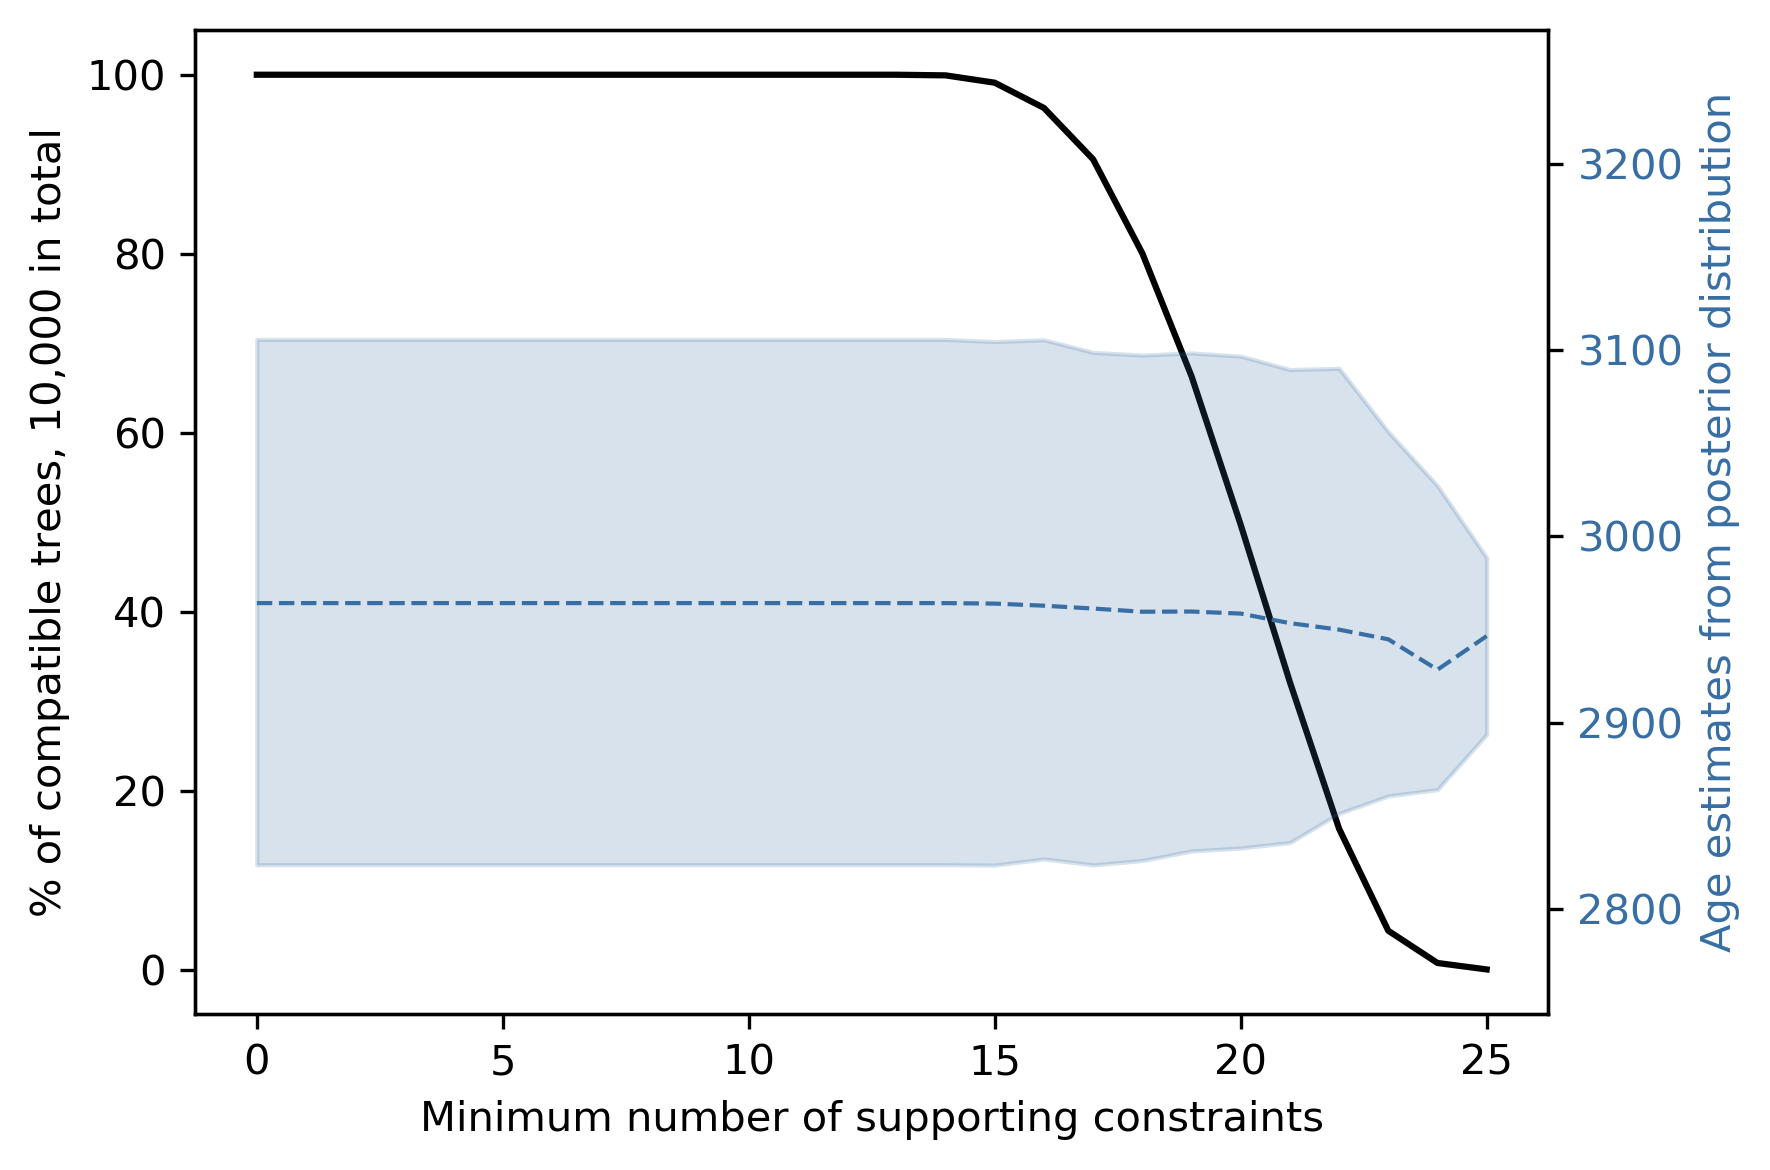

In [13]:
for node_name in target_node_descendants.keys():
    fig, ax = plt.subplots(dpi=300)
    ax.set_xlabel('Minimum number of supporting constraints')
    ax.set_ylabel(f'% of compatible trees, {num_trees:,} in total')

    ax.plot(min_compatibility_thresh,
            (min_compatibility_tree_count/num_trees)*100,
            'k-')

    twin_ax = ax.twinx()
    twin_ax.set_ylim(top   =age_estimate_HPDs[node_name]['oldest_age'],
                     bottom=age_estimate_HPDs[node_name]['youngest_age'])

    twin_ax.fill_between(min_compatibility_thresh[:len(age_estimate_HPDs[node_name]['median'])],
                         age_estimate_HPDs[node_name]['ancient_bound' ],
                         age_estimate_HPDs[node_name]['recent_bound' ],
                         color='#376EA4',
                         alpha=0.2
                        )

    twin_ax.plot(min_compatibility_thresh[:len(age_estimate_HPDs[node_name]['median'])],
                 age_estimate_HPDs[node_name]['median'],
                 c='#376EA4', ls='--', lw=1)

    twin_ax.tick_params(axis='y', labelcolor='#376EA4')
    twin_ax.set_ylabel('Age estimates from posterior distribution', color='#376EA4')

#     fig.suptitle('Crown Cyanobacteria age estimation through incremental filtering', 
#                  fontsize=11,
#                  y=0.95)

    fig.tight_layout()
    fig.savefig(f'../BE_noChlorobact_attrition_curve-{node_name}.pdf', dpi=300);